In [99]:
from IPython.display import clear_output
clear_output()

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

import lazypredict
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')

## Read the datasets

In [101]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

RANDOM_STATE = 12
FOLDS = 5
STRATEGY = 'median'

## Explore the training set

In [102]:
train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [103]:
train.count()

PassengerId     8693
HomePlanet      8492
CryoSleep       8476
Cabin           8494
Destination     8511
Age             8514
VIP             8490
RoomService     8512
FoodCourt       8510
ShoppingMall    8485
Spa             8510
VRDeck          8505
Name            8493
Transported     8693
dtype: int64

In [104]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [105]:
print(train.shape)
# print('Num of rows in training set: {}'.format(train.shape[0]))
print(f'Num of rows in training set: {train.shape[0]}')
print(f'Num of cols in training set: {train.shape[1]}')
print(f'Num of vals in training set: {train.count().sum()}')
print(f'Num of rows in training set: {sum(train.isna().sum())}')

(8693, 14)
Num of rows in training set: 8693
Num of cols in training set: 14
Num of vals in training set: 119378
Num of rows in training set: 2324


In [106]:
print(train.isna().sum().sort_values(ascending = False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
Transported       0
PassengerId       0
dtype: int64


In [107]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


## Explore Test set

In [108]:
test.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez
5,0027_01,Earth,False,F/7/P,TRAPPIST-1e,31.00,False,0.00,1615.00,263.00,113.00,60.00,Karlen Ricks
6,0029_01,Europa,True,B/2/P,55 Cancri e,21.00,False,0.00,nan,0.00,0.00,0.00,Aldah Ainserfle
7,0032_01,Europa,True,D/0/S,TRAPPIST-1e,20.00,False,0.00,0.00,0.00,0.00,0.00,Acrabi Pringry
8,0032_02,Europa,True,D/0/S,55 Cancri e,23.00,False,0.00,0.00,0.00,0.00,0.00,Dhena Pringry
9,0033_01,Earth,False,F/7/S,55 Cancri e,24.00,False,0.00,639.00,0.00,0.00,0.00,Eliana Delazarson


In [109]:
print(f'Num of rows in test set: {test.shape[0]}')
print(f'Num of columns in test set: {test.shape[1]}')
print(f'Num of values in test set: {test.count().sum()}')
print(f'Num of rows with missing values in test set: {sum(test.isna().sum())}')

Num of rows in test set: 4277
Num of columns in test set: 13
Num of values in test set: 54484
Num of rows with missing values in test set: 1117


In [110]:
print((test.isna().sum().sort_values(ascending = False)))

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
VIP              93
CryoSleep        93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [111]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


## Exploratory Data Analysis (EDA)

In [112]:
train.drop(['PassengerId'], axis = 1, inplace = True)
test.drop(['PassengerId'], axis = 1, inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12

In [113]:
train.iloc[:, :-1]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy
1,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines
2,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent
3,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent
4,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,A/98/P,55 Cancri e,41.00,True,0.00,6819.00,0.00,1643.00,74.00,Gravior Noxnuther
8689,Earth,True,G/1499/S,PSO J318.5-22,18.00,False,0.00,0.00,0.00,0.00,0.00,Kurta Mondalley
8690,Earth,False,G/1500/S,TRAPPIST-1e,26.00,False,0.00,0.00,1872.00,1.00,0.00,Fayey Connon
8691,Europa,False,E/608/S,55 Cancri e,32.00,False,0.00,1049.00,0.00,353.00,3235.00,Celeon Hontichre


In [114]:
train.iloc[:, :-1].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [115]:
train.iloc[:, :-1].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00


In [116]:
train.iloc[:, :-1].describe().T.sort_values(by = 'std', ascending = False)

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00


In [117]:
train.iloc[:, :-1].describe().T.sort_values(by = 'std', ascending = False).style.background_gradient(cmap = 'GnBu')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00


In [118]:
train.iloc[:, :-1].describe().T.sort_values(by = 'std', ascending = False)\
    .style.background_gradient(cmap = 'GnBu')\
    .bar(subset = ['max'], color = '#BB0000')\
    .bar(subset = ['mean'], color = 'green')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00


### Col wise Null Value distribution

In [119]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0, ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0, ascending = False)[:-1]

fig = make_subplots(rows = 1,
                    cols = 2,
                    column_titles = ['Train Data', 'Test Data'],
                    x_title = 'Missing Values')

fig.add_trace(go.Bar(x = train_null[0],
                     y = train_null.index,
                     orientation = 'h',
                     marker = dict(color = [n for n in range(train_null.shape[0])],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 1,
                                   coloraxis = 'coloraxis')),
              1, 1)

fig.add_trace(go.Bar(x = test_null[0],
                     y = test_null.index,
                     orientation = 'h',
                     marker = dict(color = [n for n in range(test_null.shape[0])],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 1,
                                   coloraxis = 'coloraxis')),
              1, 2)

fig.update_layout(showlegend = False, title_text = 'Column wise Null Value Distribution', title_x = 0.5)

### Row wise Null Value distribution

In [120]:
missing_train_row = train.isna().sum(axis = 1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/ test.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis = 1)
missing_test_row =pd.DataFrame(missing_test_row.value_counts()/ test.shape[0]).reset_index()

missing_train_row.columns = ['No', 'Count']
missing_test_row.columns = ['No', 'Count']
missing_train_row['Count'] = missing_train_row['Count'] * 100
missing_test_row['Count'] = missing_test_row['Count'] * 100

fig = make_subplots(rows = 1,
                    cols = 2,
                    column_titles = ['Train Data', 'Test Data'],
                    x_title = 'Missing Values')

fig.add_trace(go.Bar(x = missing_train_row['No'],
                     y = missing_train_row['Count'],
                     orientation = 'v',
                     marker = dict(color = [n for n in range(missing_train_row.shape[0])],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 2,
                                   coloraxis = 'coloraxis')),
              1, 1)

fig.add_trace(go.Bar(x = missing_test_row['No'],
                     y = missing_test_row['Count'],
                     orientation = 'v',
                     marker = dict(color = [n for n in range(missing_test_row.shape[0])],
                                   line_color = 'rgb(0, 0, 0)',
                                   line_width = 2,
                                   coloraxis = 'coloraxis')),
              1, 2)

fig.update_layout(showlegend = False, title_text = 'Row wise Null Value Distribution', title_x = 0.5)

### Continuous and Categorical Data Distribution

In [121]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis = 0)
text_features = ['Cabin', 'Name']
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features]

del df

print(f'Total num of features: {len(FEATURES)}')
print(f'Num of continuous features: {len(cont_features)}')
print(f'Num of categorical features: {len(cat_features)}')
print(f'Num of text features: {len(text_features)}')

labels = ['Categorical', 'Continuous', 'Text']
values = [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data = [go.Pie(labels = labels,
                              values = values,
                              pull = [0.1, 0, 0],
                              marker = dict(colors = colors,
                                            line = dict(color = '#000000',
                                                        width = 2)
                                            )
                               )
                        ]
                )
fig.show()

Total num of features: 12
Num of continuous features: 6
Num of categorical features: 4
Num of text features: 2


### Feature Distribution of Continuous Features

#### Distribution of Age

In [122]:
train_age = train.copy()
test_age = test.copy()

train_age['type'] = 'Train'
test_age['type'] = 'Test'

age_df = pd.concat([train_age, test_age])

fig = px.histogram(data_frame = age_df,
                   x = 'Age',
                   color = 'type',
                   color_discrete_sequence = ['#58D68D', '#DE3163'],
                   marginal = 'box',
                   nbins = 100,
                   )

fig.update_layout(title = 'Distribution of Age', title_x = 0.5)
fig.show()

#### Feature Distribution of Categorical Features

0       Europa
1        Earth
2       Europa
3       Europa
4        Earth
         ...  
8688    Europa
8689     Earth
8690     Earth
8691    Europa
8692    Europa
Name: HomePlanet, Length: 8693, dtype: object


ValueError: could not convert string to float: 'Earth'

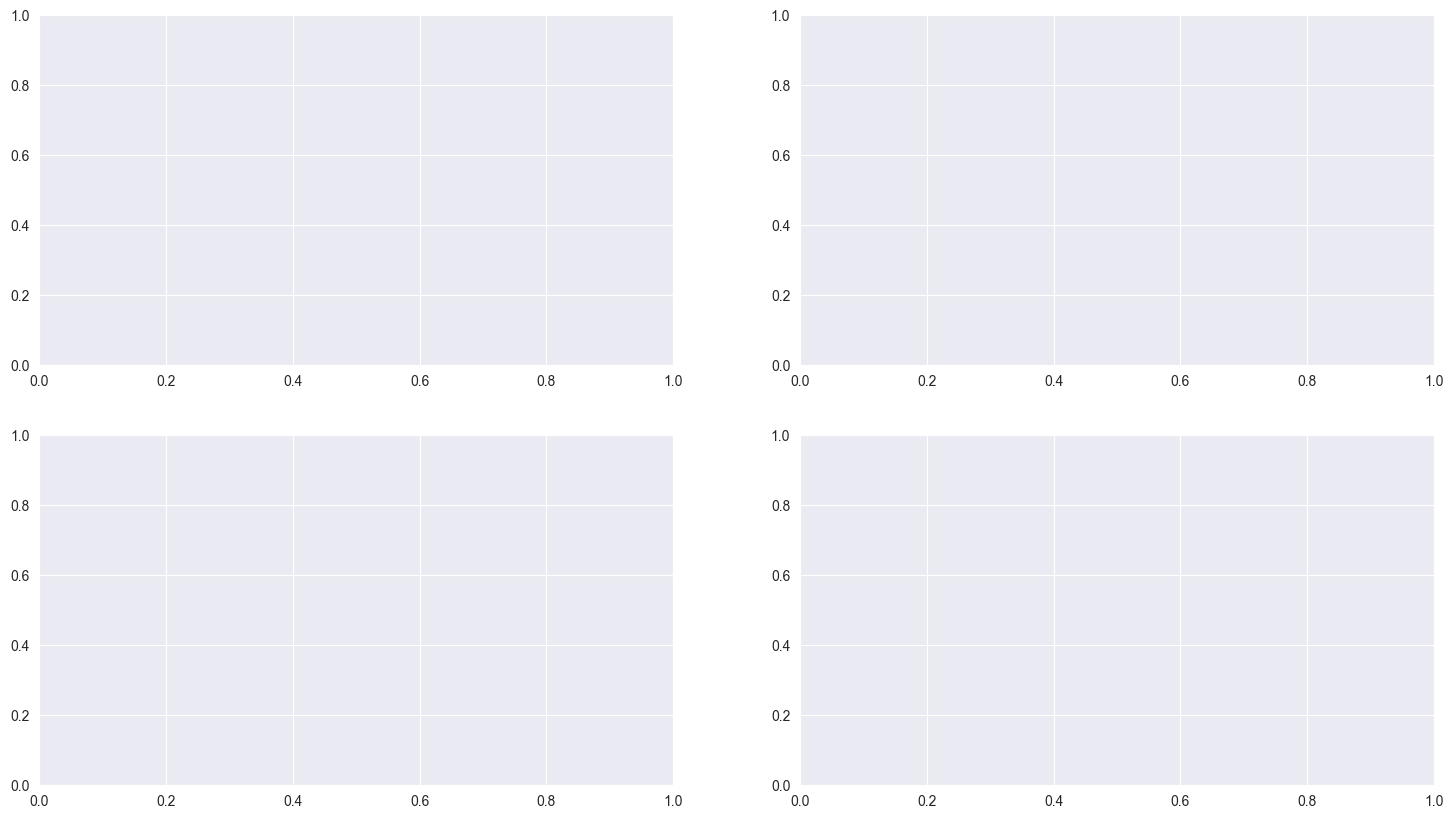

In [126]:
if not cat_features:
    print('No Categorical features')
else:
    n_rows = 2
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize = (18, 10))

    for r in range(n_rows):
        for c in range(n_cols):
            col = cat_features[r * n_cols + c]
            print(train[col])
            sns.countplot(train[col], ax = axes[r, c], palette = 'viridis', label = 'Train data')
            sns.countplot(test[col], ax = axes[r, c], palette = 'magma', label = 'Test data')
            axes[r, c].legend()
            axes[r, c].set_ylabel('')
            axes[r, c].set_xlabel(col, fontsize = 20)
            axes[r, c].tick_params(labelsize = 10, width = 0.5)
            axes[r, c].xaxis.offsetText.set_fontsize(4)
            axes[r, c].yaxis.offsetText.set_fontsize(4)

    plt.show()